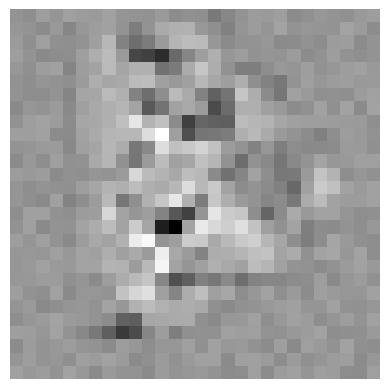

In [81]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model

# Load the pre-trained model
loaded_model = load_model('./models/cnn_std')

# Define dimensions
img_width = 28
img_height = 28

# Choose an intermediate convolutional layer for deep dreaming
deep_dream_model = Model(inputs=loaded_model.input, outputs=loaded_model.layers[2].output)

# Define the loss function
def compute_loss(input_image):
    activation = deep_dream_model(input_image)
    # Use the full activation of a specific channel if slicing is not feasible
    filter_activation = activation[..., 1]
    return tf.reduce_mean(filter_activation)

# Define gradient ascent step
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

# Visualize a filter using gradient ascent
def visualize_filter():
    iterations = 30  # Adjust as needed
    learning_rate = 1.0  # Lower learning rate for stability
    img = tf.random.uniform((1, img_width, img_height, 1))  # Random starting image
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)

    return loss, img

# Run the visualization
loss, img = visualize_filter()

# Normalize and display the resulting dream image
printable_img = img[0]
printable_img = (printable_img - tf.reduce_min(printable_img)) / (tf.reduce_max(printable_img) - tf.reduce_min(printable_img))
plt.imshow(printable_img, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Load the trained model (replace with your actual model path)
model = cnn_std

# Define the Deep Dream function
def deep_dream(input_image, target_class, dream_model, iterations=30, step=1.0):
    input_image = tf.Variable(np.expand_dims(input_image, axis=0), dtype=tf.float32)
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            predictions = dream_model(input_image)
            loss = tf.reduce_mean(predictions[:, :, :, target_class])  # Focus on target class

        grads = tape.gradient(loss, input_image)
        grads /= (tf.math.reduce_std(grads) + 1e-8)  # Normalize gradients
        input_image.assign_add(step * grads)  # Update the image

    return input_image.numpy()[0]

# Specify the layers you want to visualize
layer_names = ["conv2d_2"]  # Replace with your layer names
dream_images = {}

# Generate Deep Dream images for classes 2 and 9
for layer_name in layer_names:
    layer_output = model.get_layer(layer_name).output
    dream_model = Model(inputs=model.input, outputs=layer_output)

    for target_class in [2, 9]:
        base_image = np.random.random((28, 28))  # Random noise as starting image
        dream_image = deep_dream(base_image, target_class=target_class, dream_model=dream_model)
        dream_images[(layer_name, target_class)] = dream_image

# Plot all images
fig, axes = plt.subplots(len(layer_names), 2, figsize=(10, 15))

for i, layer_name in enumerate(layer_names):
    for j, target_class in enumerate([2, 9]):
        ax = axes[i, j]
        ax.imshow(dream_images[(layer_name, target_class)], cmap="viridis")
        ax.set_title(f"Class {target_class}, Layer: {layer_name}")
        ax.axis("off")

plt.tight_layout()
plt.savefig("deep_dream_digits.png", dpi=300)
plt.show()
